In [1]:
from astropy.io import fits #astropy modules for FITS IO
import numpy as np #numpy gives us better array management 
from scipy import interpolate #spline interpolation
import os #checking status of requested files

import matplotlib  #ploting
import matplotlib.pyplot as plt

%matplotlib inline

## Compile Transitfit library  
in the utils folder run:  
f2py3 -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lpthread -liomp5 --fcompiler=intelem --f90flags='-parallel -mkl -qopenmp' --f77flags='-parallel -mkl -qopenmp'  

In [ ]:
import spgen as spgen #Python Routines for SpecGen Routines and wrappers for fast-Transit-model.

In [2]:
# For Debuging
import importlib

In [48]:
importlib.reload(spgen) 

<module 'spgen' from '/home/rowe/Documents/jwst/jwst-mtl/SOSS/specgen/spgen.py'>

## Notebook Parameters  
These parameters set up the work environment.

In [4]:
workdir='/data/JWST/' #root folder for local files

## Model Parameters

In [5]:
pars=spgen.ModelPars()              #Set up default parameters
filename=workdir+'simpars.txt'      #location of file for parameter import 
pars=spgen.read_pars(filename,pars) #read in parameter file

Not found:  rprstype1 9 rprstype 1
Linenumber:  42


## Get Instrument Response 

In [6]:
response_file=workdir+'tables/NIRISS_Throughput_STScI.fits'
response_ld,response_n0,response_n1,response_n2,response_n3,quantum_yield=spgen.readresponse(response_file)

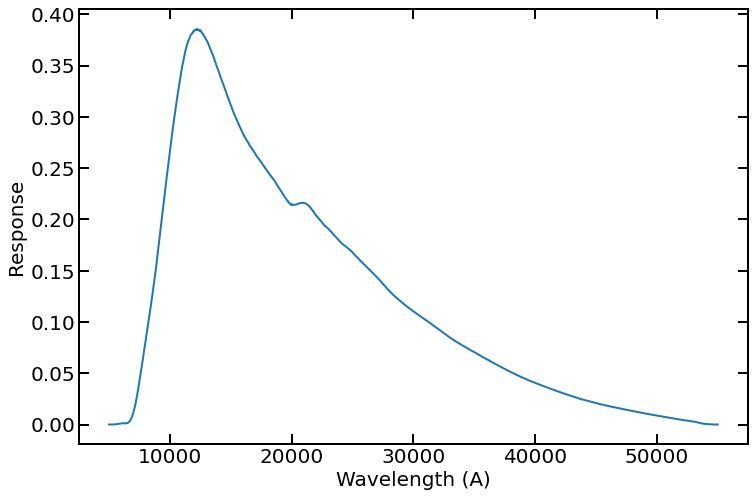

In [7]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(response_ld,response_n1,lw=2)

ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Response')

plt.show()

## Read in Stellar Atmosphere

In [8]:
starmodel_wv,starmodel_flux=spgen.readstarmodel(workdir+pars.modelfile,pars.nmodeltype)

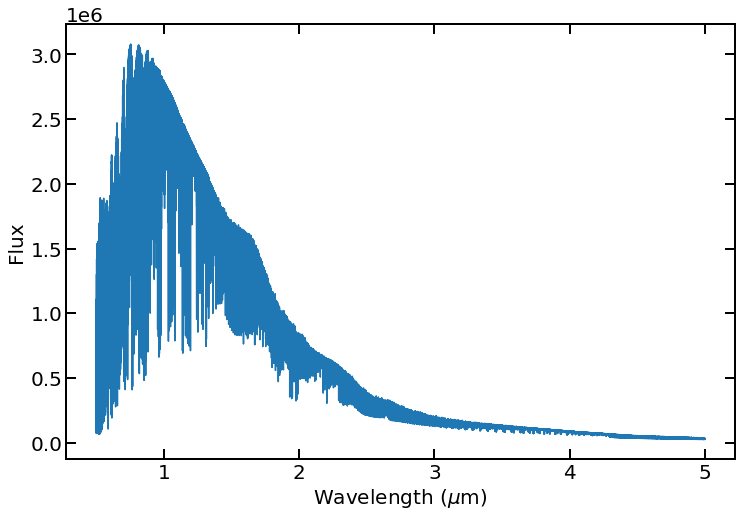

In [76]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(starmodel_wv/10000,starmodel_flux)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Flux')

plt.show()

## Read in Planet atmosphere  
todo: 
- read in limb-darkening coefficients

In [39]:
pmodeltype=2  ## Needs to be added as model parameter.  
planetmodel_wv,planetmodel_rprs=spgen.readplanetmodel(workdir+pars.pmodelfile[0],pmodeltype)

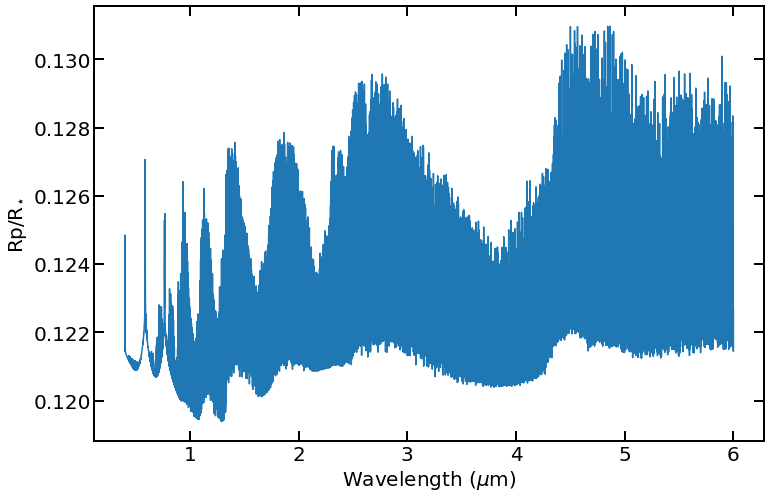

In [75]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(planetmodel_wv/10000,planetmodel_rprs)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Rp/R$_{\star}$')

plt.show()

In [12]:
print(spgen.p2w.__doc__)

Usage: w=p2w(p,noversample,ntrace) Converts x-pixel (p) to wavelength (w)
    Inputs:
      p : pixel value along dispersion axis (float) on oversampled grid.
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      w : wavelength (A)
    


In [13]:
print(spgen.w2p.__doc__)

Usage: p=w2p(w,noversample,ntrace) Converts wavelength (w) to x-pixel (p)
    Inputs:
      w : wavelength (A)
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      p : pixel value along dispersion axis (float) on oversampled grid.

    


In [14]:
print(spgen.ptrace.__doc__)

given x-pixel, return y-position based on trace
    Usage:
    py = ptrace(px,noversample,ntrace)

    Inputs:
      px : pixel on dispersion axis (float) on oversampled grid.
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      py : pixel on spatial axis (float) on oversampled grid.
    


## Resample Spectra onto a common grid  
Todo:  
- ~~common wavelength grid~~
- ~~bin starflux~~
- ~~bin planet r/R*~~
- bin limb-darkening

In [81]:
#Get wavelength spacing to use for resampling
dw,dwflag=spgen.get_dw(starmodel_wv,planetmodel_wv,norder,pars)
print(dw,dwflag)

0.9599941999986186 0


In [88]:
# To be moved to spgen.py after limb-darkening has been added.
def resample_models(dw,starmodel_wv,starmodel_flux,planetmodel_wv,planetmodel_rprs,norder,pars):

    #common grid
    wv1=spgen.p2w(pars.xout+1,1,norder)
    wv2=spgen.p2w(0,1,norder)
    #wv=np.arange(wv1,wv2,dw)
    bmax=int((wv2-wv1)/dw)

    #bin star model
    bin_starmodel_wv=[]
    bin_starmodel_flux=[]
    bin=[int((s_wv-wv1)/dw) for s_wv in starmodel_wv]
    bin=np.array(bin)
    for b in range(0,bmax+1):
        npt=len(bin[bin==b])
        #nc=nc+npt
        if npt>0:
            #print(npt)
            bin_starmodel_wv.append(np.mean(starmodel_wv[bin==b]))
            bin_starmodel_flux.append(np.mean(starmodel_flux[bin==b]))
    bin_starmodel_wv=np.array(bin_starmodel_wv)
    bin_starmodel_flux=np.array(bin_starmodel_flux)


    #bin planet model
    bin_planetmodel_wv=[]
    bin_planetmodel_rprs=[]
    bin=[int((s_wv-wv1)/dw) for s_wv in planetmodel_wv]
    bin=np.array(bin)
    for b in range(0,bmax+1):
        npt=len(bin[bin==b])
        #nc=nc+npt
        if npt>0:
            #print(npt)
            bin_planetmodel_wv.append(np.mean(planetmodel_wv[bin==b]))
            bin_planetmodel_rprs.append(np.mean(planetmodel_rprs[bin==b]))
    bin_planetmodel_wv=np.array(bin_planetmodel_wv)
    bin_planetmodel_rprs=np.array(bin_planetmodel_rprs)
    
    return bin_starmodel_wv,bin_starmodel_flux,bin_planetmodel_wv,bin_planetmodel_rprs


In [90]:
norder=1
bin_starmodel_wv,bin_starmodel_flux,bin_planetmodel_wv,bin_planetmodel_rprs=\
  resample_models(dw,starmodel_wv,starmodel_flux,planetmodel_wv,planetmodel_rprs,norder,pars)

In [91]:
print(len(bin_starmodel_wv))
print(len(bin_planetmodel_wv))

20369
20369


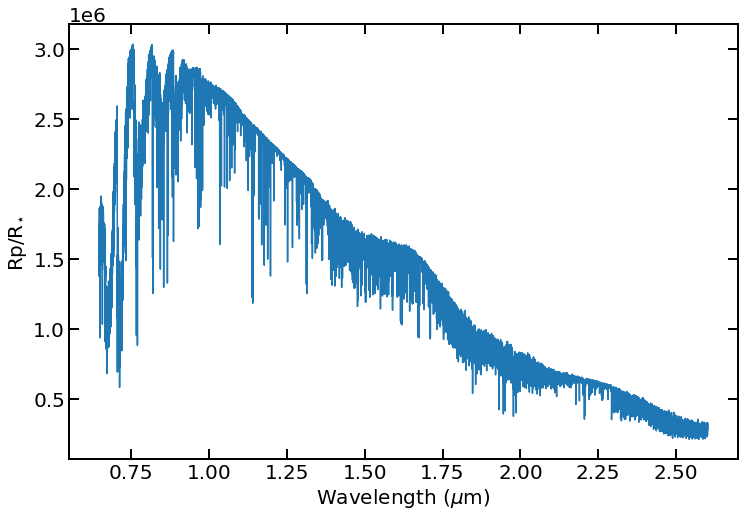

In [92]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(bin_starmodel_wv/10000,bin_starmodel_flux)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Rp/R$_{\star}$')

plt.show()

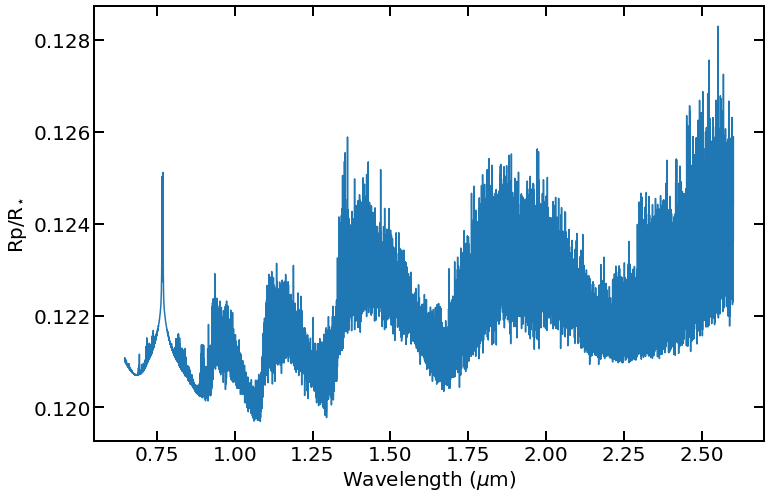

In [93]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(bin_planetmodel_wv/10000,bin_planetmodel_rprs)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Rp/R$_{\star}$')

plt.show()

## Transit Model  
todo:  
- create solin array from pars.sol for each wavelength.
- calculate transit-depth at each wavelength
- requires integration time and b(t)

In [97]:
time=np.array([0.0])     #time
itime=np.array([0.0001]) #integration time (days)
ans = spgen.transitmodel (pars.sol[:8+10*pars.nplanet], time, itime)

In [98]:
pars.sol[:8+10*pars.nplanet]

array([1. , 0. , 3. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. ])

## Generate unconvolved image with n=1 order  
todo:
- ~~use resampled star,planet models~~
- use transit model  
- scale total flux on detector using ETC output

In [94]:
#array to hold synthetic image
xmax=pars.xout*pars.noversample
ymax=pars.yout*pars.noversample

pixels=np.zeros((xmax,ymax))

norder=1 #Order to use.

response_spl = interpolate.splrep(response_ld, response_n1, s=0)
quantum_yield_spl  = interpolate.splrep(response_ld, quantum_yield, s=0)
rmax=np.max(response_ld)
rmin=np.min(response_ld)


for k in range(bin_starmodel_wv.shape[0]):
    
    w=bin_starmodel_wv[k]
    i=spgen.w2p(w,pars.noversample,norder)
    j=spgen.ptrace(i,pars.noversample,norder)
    
    if (i<=xmax+1) & (i>=0) & (j<=ymax+1) & (j>=0): #check if pixel is on grid
        
        if w < rmax and w > rmin:
            response_one = interpolate.splev(w, response_spl, der=0)
            quantum_yield_one = interpolate.splev(w, quantum_yield_spl, der=0)
        else:
            response_one = 0
            quantum_yield_one = 0
        flux=bin_starmodel_flux[k]*response_one*quantum_yield_one
        pixels=spgen.addflux2pix(i,j,pixels,flux)


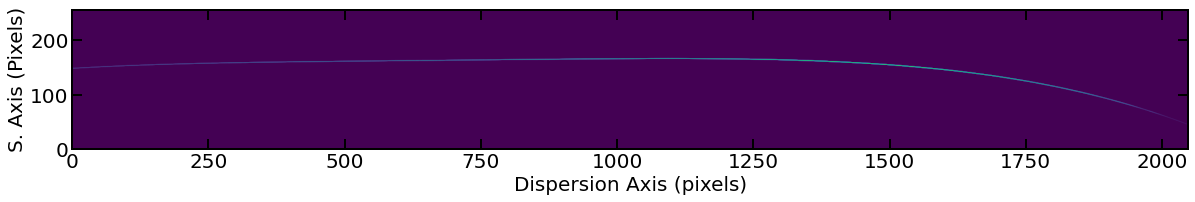

In [95]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(20,4)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.imshow(np.transpose(np.sqrt(pixels)))
ax.axis((0,pixels.shape[0],0,pixels.shape[1]))

ax.set_xlabel('Dispersion Axis (pixels)')
ax.set_ylabel('S. Axis (Pixels)')
plt.show()

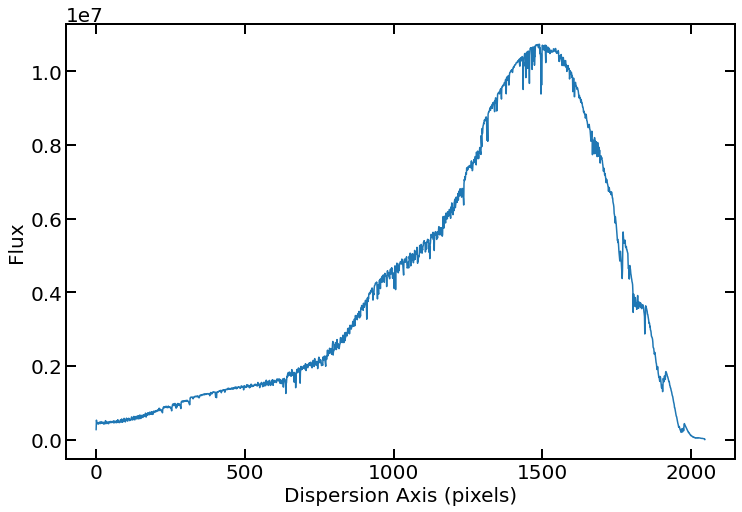

In [96]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(np.sum(pixels,axis=1),label='Column Sum') #Plot the sum of each column

ax.set_xlabel('Dispersion Axis (pixels)')
ax.set_ylabel('Flux')

plt.show()

## Convolve Image with PSF